In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pqr

In [3]:
prices = pd.read_excel('~/notebooks/pqr/factors/monthlyprice.xlsx', parse_dates=True, index_col=0).astype(float)
pe = pd.read_excel('~/notebooks/pqr/factors/PE.xlsx', parse_dates=True, index_col=0).astype(float)
volume = pd.read_excel('~/notebooks/pqr/factors/betafilter.xlsx', parse_dates=True, index_col=0).astype(float)

In [4]:
prices, pe, volume = pqr.correct_matrices(prices, pe, volume)
prices, pe, volume = pqr.replace_with_nan(prices, pe, volume, to_replace=[0])

In [5]:
value = pqr.Factor(pe)
value.transform(
    is_dynamic=False,
    looking_back_period=3,
    lag_period=0,
    holding_period=3
)

liquidity = pqr.Factor(volume)
liquidity.look_back()

liquidity_filter = liquidity.data >= 10_000_000
value.prefilter(liquidity_filter)

In [6]:
benchmark = pqr.Benchmark()
benchmark.from_stock_universe(
    prices,
    liquidity_filter
)

Benchmark('benchmark')

In [7]:
portfolios = pqr.fit_factor_model(
    stock_prices=prices,
    factor=value
)

,"q(0.00, 0.33)","q(0.33, 0.67)","q(0.67, 1.00)"
"Alpha, %",0.28,-0.27,0.14
Beta,0.96,1.02,0.93
Sharpe Ratio,0.72,0.47,0.65
"Mean Return, %",1.53,1.06,1.35
"Volatility, %",7.35,7.78,7.20
"Excess Return, %",0.25,-0.22,0.07
Benchmark Correlation,0.93,0.94,0.92
"Win Rate, %",59.51,58.05,59.02
"Maximum Drawdown, %",-92.47,-104.64,-91.88


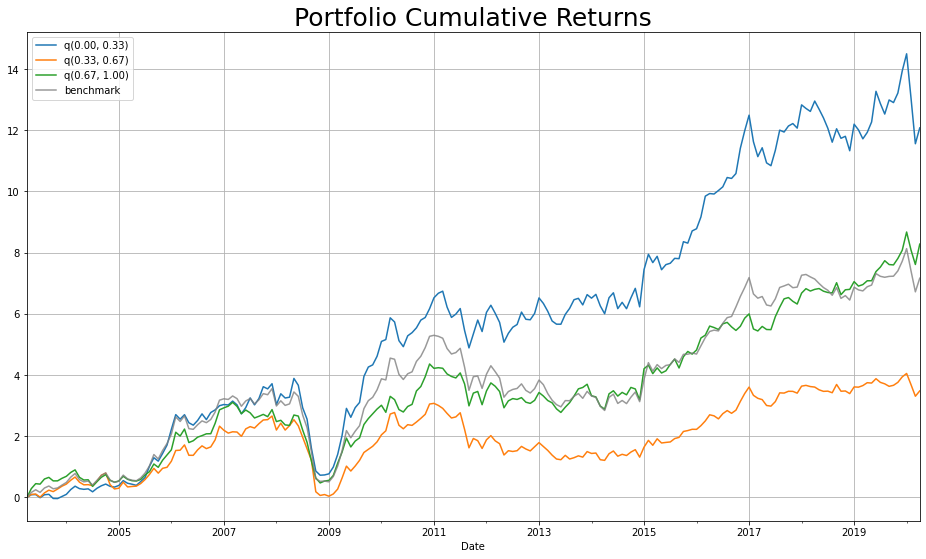

In [8]:
pqr.factor_model_tear_sheet(
    *portfolios,
    benchmark=benchmark
)